In [22]:
import pennylane as qml
import jax
from jax import numpy as jnp
import optax
import catalyst

n_wires = 4
weights = jnp.ones((4,n_wires))
bias = jnp.array([1.0])
opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

@qml.qnode(qml.device("lightning.qubit", wires=n_wires), diff_method="best")
def circuit(x, weights):

    # Embedding Ansatz
    for i in range(n_wires):
        qml.RY(2*jnp.arccos(x),wires = i)

    # Variational Ansatz   
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_wires])

    # Total magnetization in z-direction as cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

@jax.jit
def loss_fnc(weights):
    # Loss function of: du/dx = 1, u(0) = 0
    x = jnp.linspace(0,0.99,21)
    _dudx = jax.grad(circuit, argnums=0)
    dudx = jnp.array([_dudx(i, weights) for i in x])

    loss_diff = jnp.mean((dudx - jnp.ones_like(dudx))**2)
    loss_initial = jnp.mean((circuit(jnp.array(0.0),weights))**2)
    
    return loss_diff + loss_initial

def optimize(weights, opt_state, n=20):
    loss_history = []

    for i in range(1,n+1):
        loss_val, grads = jax.value_and_grad(loss_fnc)(weights)
        updates, opt_state = opt.update(grads, opt_state)
        weights = optax.apply_updates(weights, updates)
        print(f"Step: {i}  Loss: {loss_val}")
        loss_history.append(loss_val)

    return weights, opt_state, loss_history


In [23]:
weights, opt_state, loss_history = optimize(weights, opt_state)

ValueError: Pure callbacks do not support JVP. Please use `jax.custom_jvp` to use callbacks while taking gradients.

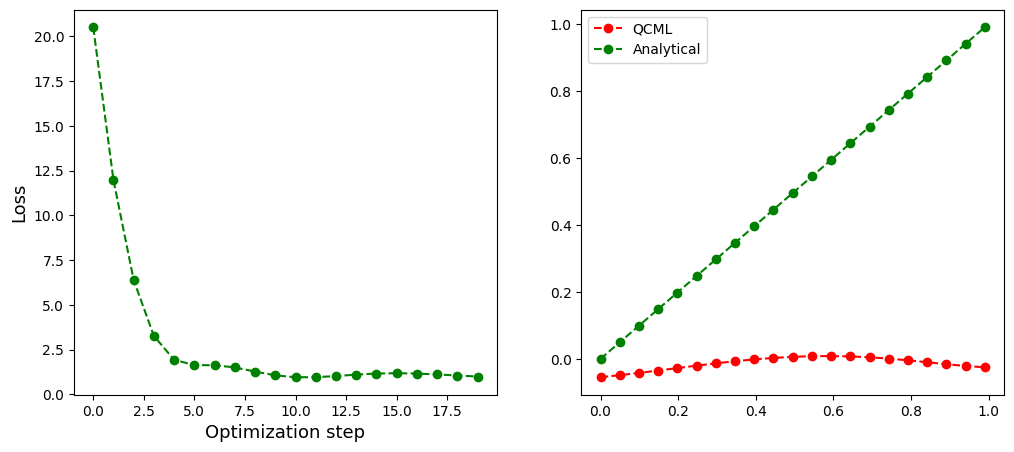

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = jnp.linspace(0,0.99,21)
f_qc = circuit(x,weights)
f_an = x
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()

In [24]:
qml.about()

Name: PennyLane
Version: 0.35.1
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/stefan/.local/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Catalyst, PennyLane_Lightning

Platform info:           Linux-6.5.13-7-MANJARO-x86_64-with-glibc2.39
Python version:          3.11.8
Numpy version:           1.26.4
Scipy version:           1.11.4
Installed devices:
- nvidia.custatevec (PennyLane-Catalyst-0.5.0)
- nvidia.cutensornet (PennyLane-Catalyst-0.5.0)
- softwareq.qpp (PennyLane-Catalyst-0.5.0)
- default.clifford (PennyLane-0.35.1)
- default.gaussian (PennyLane-0.35.1)
- default